# Phase 4 Project

### Business Problem

Company Zen has been marketing and selling Apple and Google products for an year now. One of their main platform is Twitter and they have hired me to build a model to help them classify the sentiments on the product offering so as to enable them make informed decision to strengthen or reassess their relationships with Apple and Google based on how customers are responding to the products.

### Business Understanding

Understanding customer feel and think on products is very crucial as it impacts the marketing and product offering. Twitter offers real-time insights that would help the company react quicky to feedback and possible recover service. Identifying trends and sentiment patterns early, will enable Zen outpace competitors in refining their campaigns and address customer pain points.
See below objectives that the model seeks to answer:
* Develop a model to predict the positive and negative sentiments?
* What products have the best and worst sentiments?
* Should Company Zen continue this partneship with Apple and Google?

### Data Understanding

The dataset was downloaded from CrowdFlower and is stored in the data folder. Human raters rated the sentiments in over 9,000 Tweets as positive, negative, or neither. A possible limitation on the **Is_there_an_emotion_directed_at_a_brand_or_product** is that the sentiments were rated by humans who are prone to bias depending on their emotions and understanding of the sentiment categories. It would be interesting to consider using techniques such as VADER to capture the machine labelled sentiments. See the breakdown of the columns the data is in.

**Tweet_text** -- actual text of the tweets

**Emotion_in_tweet_is_directed_at** -- who or what the emotion expressed in the tweet is directed at

**Is_there_an_emotion_directed_at_a_brand_or_product** -- whether the tweet contains an emotion directed at a specific brand or product


#### Import Libraries

In [212]:
#Import relevant libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
import re
nltk.download('punkt')
nltk.download('stopwords', quiet=True)
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from scipy.sparse.csr import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, classification_report, recall_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Load & Inspect Data

In [213]:
# Load the dataset
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
# Preview the first five rows
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


* The column names are so long. Let us proceed to **rename** for ease of access

In [214]:
# Rename columns for ease of access
df.rename(columns={
    'tweet_text': 'Text',
    'emotion_in_tweet_is_directed_at': 'Product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'
}, inplace=True)

# Preview the renamed columns
df.head()

,Text,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [215]:
#To view the shape of the dataset
df.shape

(9093, 3)

* We have 9093 tweet texts and 3 columns renamed as above.

In [216]:
#To view the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       9092 non-null   object
 1   Product    3291 non-null   object
 2   Sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


* We can view the datatype as object for the three columns and some missing values detected under the Non-null count which we shall further investigate.

#### Checking For Duplicates


In [217]:
# Check the number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
# Remove duplicate rows
df_cleaned = df.drop_duplicates()

Number of duplicate rows: 22


#### Checking For Missing Values

In [218]:
#To view the missing values from the cleaned dataset
df_cleaned.isnull().sum()

Text            1
Product      5789
Sentiment       0
dtype: int64

* We note that some of the tweets have the product keywords found in the second column. As a result, we will search for the keywords from the tweet column and where we find the products we shall fill the null values with it. This will help us deal with smaller numbers of null values in this column

In [219]:
# Example list of product names
product_keywords = ['iPad', 'Apple', 'Google', 'iPhone', 'Android App', 'Android', 'iPad or iPhone App']

# Function to extract product name from tweet text
def extract_product(text):
    if isinstance(text, str):  # Check if the text is a valid string
        for product in product_keywords:
            if product.lower() in text.lower():
                return product
    return np.nan  # Return NaN if no product is found or text is not a string

df_cleaned['Product'] = df_cleaned.apply(
    lambda row: extract_product(row['Text']) if pd.isnull(row['Product']) else row['Product'], axis=1
)

# Display the filled data
print(df_cleaned.head(10))

                                                Text             Product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   
5  @teachntech00 New iPad Apps For #SpeechTherapy...                iPad   
6                                                NaN                 NaN   
7  #SXSW is just starting, #CTIA is around the co...             Android   
8  Beautifully smart and simple idea RT @madebyma...  iPad or iPhone App   
9  Counting down the days to #sxsw plus strong Ca...               Apple   

                            Sentiment  
0                    Negative emotion  
1                    Positive emotion  
2                    Positive emotion  
3  

In [220]:
df_cleaned.isnull().sum()

Text           1
Product      760
Sentiment      0
dtype: int64

* Since we have only one null row under the Text column we shall proceed to drop this null value then fill the product null values with a placeholder as the count of null values is actually too high and the product is important to us.

In [221]:
# Drop missing values in 'Text' column
df_cleaned = df_cleaned.dropna(subset=['Text'])

# Fill missing values in 'Product' with a placeholder since we have 5789 null values.
df_cleaned['Product'].fillna('Unknown Product', inplace=True)

# Check if missing values are handled
print(df_cleaned.isnull().sum())

Text         0
Product      0
Sentiment    0
dtype: int64


No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
Name: Sentiment, dtype: int64
--------------
Percentage of Distribution
No emotion toward brand or product    60.298407
Positive emotion                      33.318376
Negative emotion                       6.383217
Name: Sentiment, dtype: float64


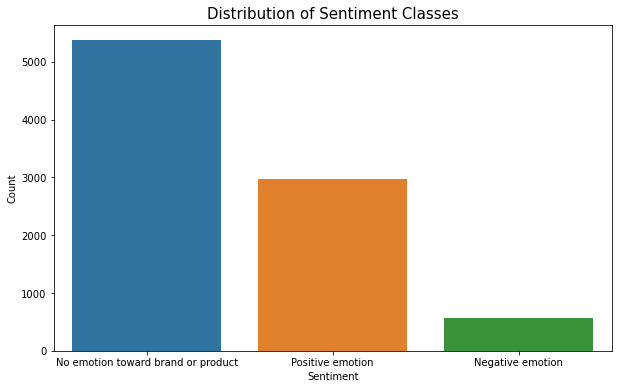

In [222]:
#Drop the "I can't tell" class label
df_cleaned = df_cleaned[(df_cleaned['Sentiment']!= "I can't tell")]
#To view the count of each unique features of our target variable
sentiment_counts = df_cleaned['Sentiment'].value_counts()
sentiment_counts_perc = df_cleaned['Sentiment'].value_counts(normalize=True)
print(sentiment_counts)
print('--------------')
print('Percentage of Distribution')
print(sentiment_counts_perc*100)
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Add labels and title
plt.xlabel('Sentiment', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Distribution of Sentiment Classes', fontsize=15)

# Show the plot
plt.show()

* Most of the data reflects neutral or no emotional response about 60%, followed by a significant share of positive sentiment 33%, and a much smaller share of negative emotions 6%. The "I can't tell" category is marginal about 1.7%.

In [223]:
#Decided to replace the no emotion toward branch or product with Neutral for use of interpretation
df_cleaned['Sentiment'] = df_cleaned['Sentiment'].replace('No emotion toward brand or product', 'Neutral')
df_cleaned['Sentiment'].value_counts() #Review the value counts of the classes of sentiments

Neutral             5375
Positive emotion    2970
Negative emotion     569
Name: Sentiment, dtype: int64

iPad                               2464
Google                             2083
Apple                              1360
iPhone                             1092
Unknown Product                     753
iPad or iPhone App                  469
Other Google product or service     292
Android                             263
Android App                         103
Other Apple product or service       35
Name: Product, dtype: int64


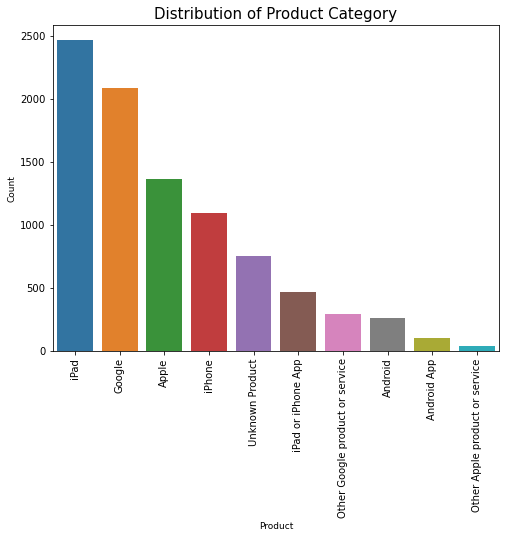

In [224]:
#To view the unique features of our product
product_counts = df_cleaned['Product'].value_counts()
print(product_counts)
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=product_counts.index, y=product_counts.values)

# Add labels and title
plt.xlabel('Product', fontsize=9)
plt.ylabel('Count', fontsize=9)
plt.title('Distribution of Product Category', fontsize=15)
plt.xticks(rotation=90)

# Show the plot
plt.show()

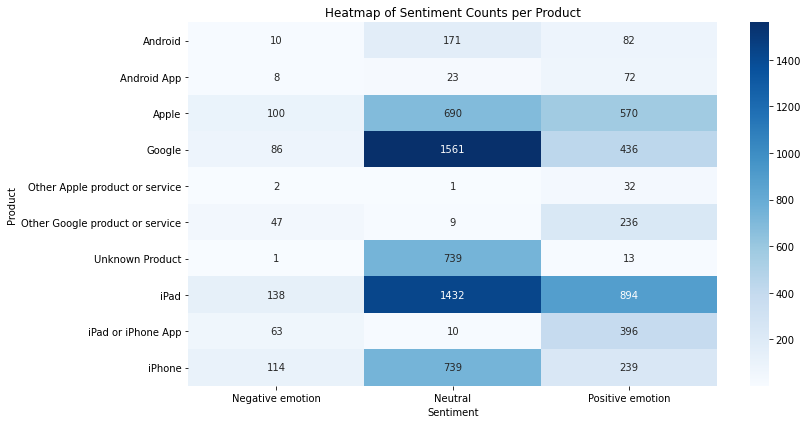

In [225]:
#Grouped the Product and Sentiments column in order to analyze the distribution of sentiments per product
sentiment_counts = df_cleaned.groupby(['Product', 'Sentiment']).size().unstack(fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sentiment_counts, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Heatmap of Sentiment Counts per Product')
plt.xlabel('Sentiment')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

#### Text Preprocessing
Here we will focus on the column Text containing the texts of the tweet and Perform Data Cleaning and Exploratory Data Analysis with nltk. Thereafter we shall proceed to split our cleaned data.

In [226]:
#initialize the stopword
stop_words = set(stopwords.words('english'))
#Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
#Create a function that will be called to clean the texts
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove Twitter usernames, hashtags, punctuation, and digits
    text = re.sub(r'@\w+|#|[^\w\s]|[\d]+', '', text)
    
    # Reduce repeated characters (e.g., "loooove" -> "love")
    text = re.sub(r'(.)\1+', r'\1\1', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join the tokens back into a single string
    text = ' '.join(tokens)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
# Apply the preprocess_text function to the 'Text' column
df_cleaned['Cleaned_Text'] = df_cleaned['Text'].apply(preprocess_text)

# Display the cleaned texts
print(df_cleaned[['Text', 'Cleaned_Text']].head(7))

                                                Text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5  @teachntech00 New iPad Apps For #SpeechTherapy...   
7  #SXSW is just starting, #CTIA is around the co...   

                                        Cleaned_Text  
0  g iphone hr tweeting rise_austin dead need upg...  
1  know awesome ipadiphone app youll likely appre...  
2                           wait ipad also sale sxsw  
3  hope year festival isnt crashy year iphone app...  
4  great stuff fri sxsw marissa mayer google tim ...  
5  new ipad apps speechtherapy communication show...  
7  sxsw starting ctia around corner googleio hop ...  


#### Visualizing Top 15 Words From the Tweets

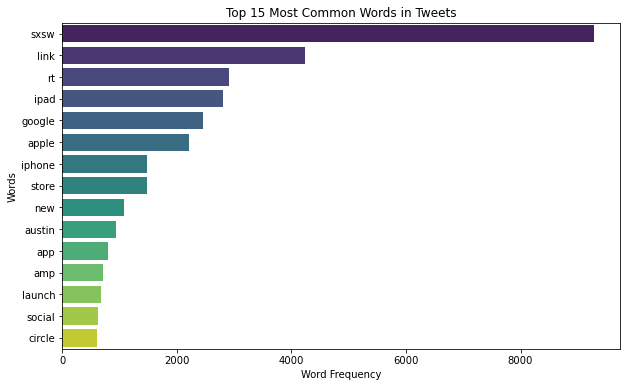

In [227]:
from collections import Counter

# Tokenize all cleaned text
all_words = ' '.join(df_cleaned['Cleaned_Text']).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the top 10 most common words
top_15_words = word_counts.most_common(15)

# Prepare data for plotting
words, counts = zip(*top_15_words)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 15 Most Common Words in Tweets')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.show()

#### Train Test Split 

In [228]:
# Define the X and y variable for the multiclass labels
X = df_cleaned['Cleaned_Text']  # Features (cleaned text)
y = df_cleaned['Sentiment']     # Target (multiclass labels)

# Step 1: Split test set (20%) for multiclass
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Split validation set (30%) for multiclass
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.30, random_state=42, stratify=y_train_val)

# Check the size of the splits for multiclass
print(f"Multiclass - Training set size: {len(X_train)}")
print(f"Multiclass - Validation set size: {len(X_val)}")
print(f"Multiclass - Test set size: {len(X_test)}")

Multiclass - Training set size: 4991
Multiclass - Validation set size: 2140
Multiclass - Test set size: 1783


#### Text Vectorization

In [229]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, and transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Display the shape of the TF-IDF matrices
print(f"TF-IDF training data shape: {X_train_tfidf.shape}")
print(f"TF-IDF validation data shape: {X_val_tfidf.shape}")
print(f"TF-IDF testing data shape: {X_test_tfidf.shape}")


TF-IDF training data shape: (4991, 5000)
TF-IDF validation data shape: (2140, 5000)
TF-IDF testing data shape: (1783, 5000)


#### Modeling

1.1 Logistic Regression

In [230]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# Train the model on the training data
logreg_model.fit(X_train_tfidf, y_train)

# Predict the sentiment on the val set
y_pred_logreg = logreg_model.predict(X_val_tfidf)
acc = accuracy_score(y_pred_logreg, y_val)
print(acc)
print(classification_report(y_val, y_pred_logreg))


0.6789719626168225
                  precision    recall  f1-score   support

Negative emotion       0.67      0.04      0.08       137
         Neutral       0.70      0.87      0.78      1290
Positive emotion       0.62      0.45      0.52       713

        accuracy                           0.68      2140
       macro avg       0.66      0.46      0.46      2140
    weighted avg       0.67      0.68      0.65      2140



A high precision indicates that the model is good at not labeling negative instances as positive.

Low recall for Negative emotion indicates the model struggles to recognize negative sentiments, likely due to class imbalance.

Overall, the model is not performing well for negative sentiments.

Overall Accuracy: 68% of predictions were correct across all classes. However, accuracy can be misleading in imbalanced datasets, as it does not account for how well the model performs on each class.

#### Cross Validation on the Baseline Model

In [233]:
logreg_cv = cross_val_score(logreg_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
logreg_cv.mean()

0.6804211024651907

The accuracy score slightly improves with the cross-validation method.

### Handling Class Imbalance Using Smote

In [236]:
# Step 3: Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Check the class distribution before and after SMOTE
print("Original training set:", Counter(y_train))
print("Resampled training set:", Counter(y_train_resampled))

Original training set: Counter({'Neutral': 3010, 'Positive emotion': 1663, 'Negative emotion': 318})
Resampled training set: Counter({'Neutral': 3010, 'Positive emotion': 3010, 'Negative emotion': 3010})


#### Logistic Regression With Balanced Classes

In [239]:
# Retrain the Logistic Regression model with the balanced data
logreg_model_balanced = LogisticRegression(max_iter=1000)
# Train the model on the training data
logreg_model_balanced.fit(X_train_resampled, y_train_resampled)

# Predict the sentiment on the val set
y_pred_logreg = logreg_model_balanced.predict(X_val_tfidf)
acc = accuracy_score(y_pred_logreg, y_val)
print(acc)
print(classification_report(y_val, y_pred_logreg))

0.6383177570093458
                  precision    recall  f1-score   support

Negative emotion       0.29      0.47      0.36       137
         Neutral       0.76      0.68      0.72      1290
Positive emotion       0.55      0.60      0.58       713

        accuracy                           0.64      2140
       macro avg       0.54      0.58      0.55      2140
    weighted avg       0.66      0.64      0.65      2140



Negative Emotion: This indicate improved recall but lower precision. This means the model is identifying more negative instances, but many predicted negatives are false positives. This is an improvement but still indicates room for refinement.

Neutral Emotion: Precision is high but has dropped slightly, indicating that while the model is still reliable, it might be misclassifying some instances.

Positive Emotion: Overall performance improved with better recall and slightly reduced precision, reflecting a balanced identification of positive sentiments.

The improved recall is critical as the model now can classify the negative sentiments.

1.2 Naive Bayes Classification

In [248]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Fit the model to the training data
baseline_model.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = baseline_model.predict(X_val_tfidf)

# Generate classification report
report = classification_report(y_val, y_val_pred)
print(report)

                  precision    recall  f1-score   support

Negative emotion       0.25      0.57      0.35       137
         Neutral       0.77      0.56      0.65      1290
Positive emotion       0.51      0.64      0.56       713

        accuracy                           0.59      2140
       macro avg       0.51      0.59      0.52      2140
    weighted avg       0.65      0.59      0.60      2140



Validation Set Performance:
                  precision    recall  f1-score   support

Negative emotion       0.52      0.21      0.30       137
         Neutral       0.70      0.83      0.76      1290
Positive emotion       0.59      0.47      0.53       713

        accuracy                           0.67      2140
       macro avg       0.60      0.50      0.53      2140
    weighted avg       0.66      0.67      0.65      2140



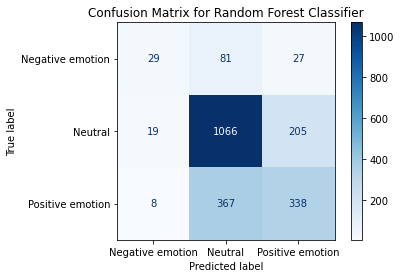

In [244]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model on the resampled training data
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on validation set
y_val_pred = rf_classifier.predict(X_val_tfidf)

# Evaluation on validation set
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cnf_matrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [253]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Create a pipeline with RandomForestClassifier
pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
# Define the parameter grid for Grid Search
param_grid = {
    'rf__n_estimators': [50, 200, 250],
    'rf__max_depth': [None, 10, 5],
    'rf__min_samples_split': [2, 4],
    'rf__min_samples_leaf': [1, 2],
}
# Initialize Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Fit the model on the training data (assumes you have X_train and y_train)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best Score: 0.8468451993534261


Validation Set Performance:
                  precision    recall  f1-score   support

Negative emotion       0.52      0.22      0.31       137
         Neutral       0.70      0.83      0.76      1290
Positive emotion       0.60      0.47      0.53       713

        accuracy                           0.67      2140
       macro avg       0.61      0.51      0.53      2140
    weighted avg       0.66      0.67      0.66      2140



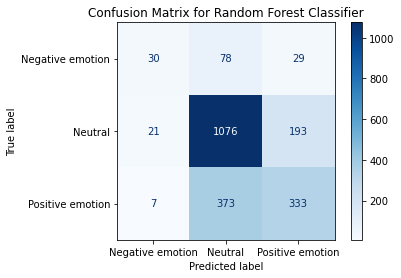

In [254]:
# Predict on the validation set
y_val_pred = grid_search.best_estimator_.predict(X_val_tfidf)

# Evaluation on the validation set
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cnf_matrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=grid_search.best_estimator_.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [200]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# # Initialize VADER Sentiment Analyzer
# analyzer = SentimentIntensityAnalyzer()

# # Function to analyze sentiment
# def get_sentiment(text):
#     scores = analyzer.polarity_scores(text)
#     # Determine overall sentiment
#     if scores['compound'] >= 0.05:
#         return 'Positive'
#     elif scores['compound'] <= -0.05:
#         return 'Negative'
#     else:
#         return 'Neutral'

# # Apply the function to the 'Tweet' column and create a new column 'Sentiment'
# df_cleaned['Sentiment'] = df_cleaned['Text'].apply(get_sentiment)

# # Display the DataFrame with sentiments
# print(df_cleaned['Sentiment'].value_counts())